In [1]:
# !pip3 install --upgrade torch --user
# !pip3 install torchvision --user

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import pickle
import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn


from torchvision import datasets
from torchvision import transforms



In [2]:
event_step = 30720
ada_step = 12
collection_step = 960
readout_step = 800


class EventSamplerDataset(torch.utils.data.Dataset):
    def __init__(self, path_clear='/data/martemev/output_data/',
                 path_noise='/data/martemev/input_noised_data/'):
        super().__init__()
        self.path_clear = path_clear
        self.path_noise = path_noise
                
        
    def __len__(self):
        return 100

        
    def __getitem__(self, index):
        clear_data = np.load(os.path.join(self.path_clear, 'onlysignal_evt{}.npy'.format(index+1)))[:, 2:]
        noised_data = np.load(os.path.join(self.path_noise, 'event_{}_noised.npy'.format(index)))[:, 3:]
        if max([clear_data[i*2*readout_step:i*2*readout_step + collection_step].max() for i in range(12)]) == 0:
            return self.__getitem__(index+1)
        return clear_data, noised_data

In [3]:
# right now we are only returning first collection plane

class PaneSamplerDataset(torch.utils.data.Dataset):
    def __init__(self, clear_data, noised_data):
        """
        clear_data, noised_data - torch.Tensor with shapes 30720 x 4492
        """
        super().__init__()
        self.clear_data = clear_data
        self.noised_data = noised_data
        
        self.signal_panes = [1, 2, 5, 6, 9, 10]
        
    def __len__(self):
        return 6
    
    def normalize(self, im):
        return (im - im.min())/(im.max()-im.min())
        
    def __getitem__(self, ind):
        index = self.signal_panes[ind]
        clear_read_panes = self.clear_data[index*(readout_step*2 + collection_step):
                                          (index+1)*(readout_step*2 + collection_step)]
        noised_read_panes = self.noised_data[index*(readout_step*2 + collection_step):
                                            (index+1)*(readout_step*2 + collection_step)]        
        # some of the panes are all zeros
        if clear_read_panes[2*readout_step:].max() == 0:
            return self.__getitem__(ind+1) # duplicate panes 
        return self.normalize(clear_read_panes[2*readout_step:]), self.normalize(noised_read_panes[2*readout_step:])


In [4]:
def get_freer_gpu():
    os.system('nvidia-smi -q -d Memory |grep -A4 GPU|grep Free >tmp')
    memory_available = [int(x.split()[2]) for x in open('tmp', 'r').readlines()]
    return np.argmax(memory_available)


In [5]:
def pairwise_dist(arr, k):
    """
    arr: torch.Tensor with shape batch x h*w x features
    """
#     arr = arr.view(arr.shape[0], arr.shape[1] * arr.shape[2], -1)
    r_arr = torch.sum(arr * arr, dim=2, keepdim=True) # (B,N,1)
    mul = torch.matmul(arr, arr.permute(0,2,1))         # (B,M,N)
    dist = - (r_arr - 2 * mul + r_arr.permute(0,2,1))       # (B,M,N)
    return dist.topk(k=k, dim=-1)[1]


def batched_index_select(t, dim, inds):
    dummy = inds.unsqueeze(2).expand(inds.size(0), inds.size(1), t.size(2))
    out = t.gather(dim, dummy) # b x e x f
    return out


def get_closest_diff(arr, k):
    """
    arr: torch.Tensor with shape batch x h * w x features
    """
    b, hw, f = arr.shape
#     arr = arr.view(b, h*w, f)
    dists = pairwise_dist(arr, k)
    selected = batched_index_select(arr, 1, dists.view(dists.shape[0], -1)).view(b, hw, k, f)
    diff = arr.unsqueeze(2) - selected
    return diff
    

In [6]:
class NonLocalAggregation(nn.Module):
    def __init__(self, k, input_channels, out_channels, search_area=None):
        super().__init__()
        self.k = k
        self.diff_fc = nn.Linear(input_channels, out_channels)
        self.w_self = nn.Linear(input_channels, out_channels)
        self.bias = nn.Parameter(torch.randn(out_channels), requires_grad=True)
        
    def forward(self, x):
        """
        x: torch.Tensor with shape batch x features x h x w
        """
        x = x.permute(0, 2, 3, 1)
        b, h, w, f = x.shape
        x = x.view(b, h*w, f)
        
        closest_graph = get_closest_diff(x, self.k)
        agg_weights = self.diff_fc(closest_graph) # look closer
        agg_self = self.w_self(x)
                
        x_new = torch.mean(agg_weights, dim=-2) + agg_self + self.bias

        return x_new.view(b, h, w, x_new.shape[-1]).permute(0, 3, 1, 2)

In [7]:
class GraphConv(nn.Module):
    def __init__(self, k, input_channels, out_channels, search_area=None):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, out_channels, 1)
        self.conv2 = nn.Conv2d(input_channels, out_channels, 3, padding=1)
        self.NLA = NonLocalAggregation(k, input_channels, out_channels)
        
    def forward(self, x):
        return torch.mean(torch.stack([self.conv1(x),
                                       self.conv2(x),
                                       self.NLA(x)]), dim=0)

In [8]:
class PreProcessBlock(nn.Module):
    def __init__(self, k, kernel_size, input_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, out_channels, kernel_size,
                              padding=(kernel_size//2, kernel_size//2))
        self.activ = nn.LeakyReLU(0.05)
        self.bn = nn.BatchNorm2d(out_channels)
        
        self.GC = GraphConv(k, out_channels, out_channels) # out_channels -> out_channels
        
    def forward(self, x):
        x = self.activ(self.conv(x))
        x = self.GC(x)
        x = self.activ(self.bn(x))
        return x

In [9]:
class Residual(nn.Module):
    def __init__(self, k, input_channels, out_channels):
        super().__init__()
        self.pipeline = nn.Sequential(
            GraphConv(k, input_channels, input_channels),
            nn.BatchNorm2d(input_channels),
            nn.LeakyReLU(0.05),
            
            GraphConv(k, input_channels, out_channels),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.05),
            
            GraphConv(k, out_channels, out_channels),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.05),
        )
        
    def forward(self, x):
        return self.pipeline(x)

In [10]:
loss_mse = nn.MSELoss()

class DNGNN(nn.Module):
    def __init__(self, k, input_channels, hidden_channels):
        super().__init__()
        self.preprocessing_blocks = nn.ModuleList([
            PreProcessBlock(k, 3, input_channels, hidden_channels),
            PreProcessBlock(k, 5, input_channels, hidden_channels),
            PreProcessBlock(k, 7, input_channels, hidden_channels),
        ])
        self.residual_1 = Residual(k, hidden_channels*3, hidden_channels)
        self.residual_2 = Residual(k, hidden_channels, hidden_channels)
        
        self.GC = GraphConv(k, hidden_channels, input_channels)
        self.downsample = nn.Sequential(
            nn.Conv2d(hidden_channels*3, hidden_channels, 1),
            nn.BatchNorm2d(hidden_channels),
            nn.LeakyReLU(0.05),
            nn.Conv2d(hidden_channels, hidden_channels, 1),
            nn.BatchNorm2d(hidden_channels),
            nn.LeakyReLU(0.05),
        )
        
    def fit_image(self, image):
        processed_image = torch.cat([block(image) for block in self.preprocessing_blocks], dim=1)
        residual_1 = self.residual_1(processed_image)
        result_1 = residual_1 + self.downsample(processed_image)
        residual_2 = self.residual_2(result_1)
        result = residual_2 + result_1
        return [processed_image, residual_1, result, self.GC(result)]
    
    def forward(self, clear_image, noised_image):
        processed_image, residual_1, residual_2, answer = self.fit_image(clear_image)
        n_processed_image, n_residual_1, n_residual_2, n_answer = self.fit_image(noised_image)
        perceptual_loss = loss_mse(processed_image, n_processed_image) + \
            loss_mse(residual_1, n_residual_1) + \
            loss_mse(residual_2, n_residual_2)
        return image + n_answer, perceptual_loss
    
    def forward_eval(self, noised_image):
        _, _, _, answer = self.fit_image(noised_image)
        return answer

    
    def forward_image(self, noised_image, chunks=16):
        splits = torch.split(torch.stack(torch.split(noised_image, 32)), 32, dim=2)[:-1]
        crops = torch.stack(splits, dim=2).view(-1, 1, 32, 32)
        crops_ = torch.split(crops, crops.shape[0]//chunks, dim=0)
        answer = torch.cat([crop + self.forward_eval(crop.cuda(device)).cpu().data for crop in crops_], dim=0)
        return answer


In [11]:
from IPython.display import clear_output

In [12]:
gpu_num = get_freer_gpu()
device = torch.device('cuda:{}'.format(gpu_num))
device

device(type='cuda', index=1)

In [13]:
model = DNGNN(8, 1, 16).cuda(device)
model.load_state_dict(torch.load('SavedModels/firstGCNN.state_dict'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [14]:
loss_mse = nn.MSELoss()

def compute_psnr(image, noised):
    return 10 * np.log10(1/loss_mse(image, noised).item())

In [15]:
def plot_diff(real, noised, denoised):
    plt.figure(figsize=(15, 15))
    
    for ind, im, noise, denoise in zip(range(1, 13, 3), real[:4], noised[:4], denoised[:4]):
        plt.subplot(4, 3, ind)
        plt.imshow(im)
        plt.yticks([])
        plt.xticks([])
        plt.title('Clear image')
        
        plt.subplot(4, 3, ind+1)
        plt.imshow(noise)
        plt.yticks([])
        plt.xticks([])
        plt.title('Noised image')
        
        plt.subplot(4, 3, ind+2)
        plt.imshow(denoise)
        plt.yticks([])
        plt.xticks([])
        plt.title('Denoised image')


    plt.show()

In [16]:
event = next(iter(EventSamplerDataset()))
plane = next(iter(PaneSamplerDataset(*event)))

In [17]:
clear, noised = plane
clear, noised = torch.Tensor(clear), torch.Tensor(noised)

In [20]:
%%time

answer = model.forward_image(noised)

CPU times: user 21.9 s, sys: 2.61 s, total: 24.5 s
Wall time: 7.24 s


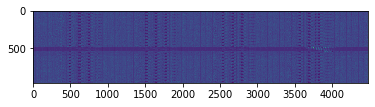

In [34]:
plt.imshow(noised[:, :4492 - (4492%32)] - answer.view(960, 4492 - (4492%32)))
plt.show()

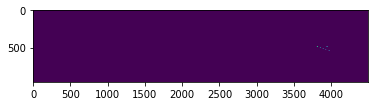

In [35]:
plt.imshow(clear)
plt.show()

In [36]:
noised[:, :4492 - (4492%32)]

tensor([[0.0875, 0.0625, 0.0688,  ..., 0.0812, 0.0750, 0.0812],
        [0.0750, 0.0812, 0.0812,  ..., 0.0688, 0.0875, 0.0812],
        [0.0812, 0.0750, 0.0938,  ..., 0.0625, 0.0437, 0.0812],
        ...,
        [0.1063, 0.1000, 0.0688,  ..., 0.0688, 0.0812, 0.0750],
        [0.0625, 0.1063, 0.0625,  ..., 0.0812, 0.0375, 0.0812],
        [0.0875, 0.0500, 0.0437,  ..., 0.0812, 0.0875, 0.0437]])

In [37]:
answer.view(960, 4492 - (4492%32))

tensor([[0.0765, 0.0215, 0.0410,  ..., 0.0762, 0.0834, 0.0852],
        [0.1060, 0.0788, 0.0509,  ..., 0.0439, 0.0697, 0.0698],
        [0.1098, 0.0844, 0.0909,  ..., 0.0573, 0.0451, 0.0869],
        ...,
        [0.1132, 0.1001, 0.0305,  ..., 0.0576, 0.0876, 0.0783],
        [0.0812, 0.1013, 0.0495,  ..., 0.0423, 0.0240, 0.0741],
        [0.1071, 0.0491, 0.0399,  ..., 0.2231, 0.2299, 0.1158]])

In [33]:
noised[:, :4492 - (4492%32)] - answer.view(960, 4492 - (4492%32))

tensor([[ 1.0965e-02,  4.1044e-02,  2.7793e-02,  ...,  5.0546e-03,
         -8.4335e-03, -3.9401e-03],
        [-3.0956e-02,  2.4166e-03,  3.0368e-02,  ...,  2.4850e-02,
          1.7845e-02,  1.1467e-02],
        [-2.8503e-02, -9.3647e-03,  2.8736e-03,  ...,  5.1630e-03,
         -1.3312e-03, -5.6629e-03],
        ...,
        [-6.9191e-03, -1.1095e-04,  3.8243e-02,  ...,  1.1194e-02,
         -6.3164e-03, -3.2547e-03],
        [-1.8740e-02,  4.9051e-03,  1.2988e-02,  ...,  3.8940e-02,
          1.3468e-02,  7.1808e-03],
        [-1.9613e-02,  8.6017e-04,  3.8219e-03,  ..., -1.4184e-01,
         -1.4244e-01, -7.2099e-02]])

In [39]:
compute_psnr(clear[:, :4492 - (4492%32)], noised[:, :4492 - (4492%32)])

22.312075465692732

In [42]:
compute_psnr(clear[:, :4492 - (4492%32)], noised[:, :4492 - (4492%32)] - answer.view(960, 4492 - (4492%32)))

29.168669536116766

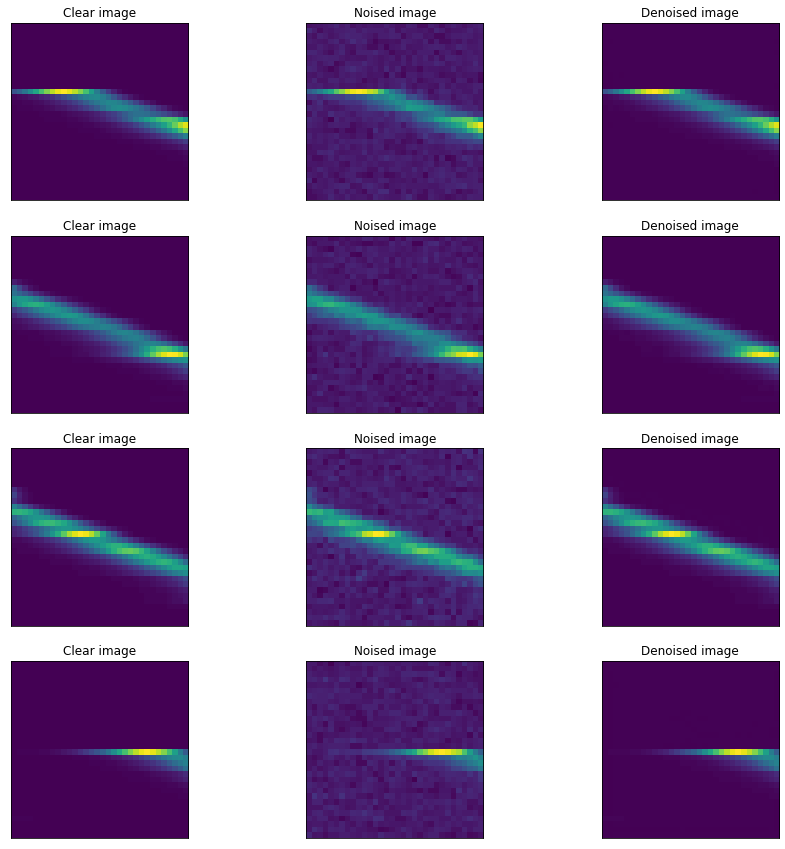


 77%|███████▋  | 14505/18750 [6:22:51<1:07:24,  1.05it/s]

KeyboardInterrupt: 

In [24]:
for ind, (image, noise_image) in enumerate(tqdm.tqdm(train_dataloader)):
    optim.zero_grad()
    image, noise_image = image.cuda(device), noise_image.cuda(device)
    denoise_image, perceptual_loss = model(image, noise_image)
    loss = loss_mse(image, denoise_image) + perceptual_loss
    loss.backward()
    optim.step()
    losses.append(loss.item())
    if ind % 10 == 0:
        print(ind, 'MSE: ', loss.item())
    if ind % 100 == 0:
        clear_output()
        plot_diff(image.cpu().view(-1, 32, 32).data.numpy(),
                  noise_image.cpu().view(-1, 32, 32).data.numpy(),
                  denoise_image.cpu().view(-1, 32, 32).data.numpy())

In [27]:
!mkdir SavedModels

In [29]:
torch.save(model, 'SavedModels/firstGCNN.model')
torch.save(model.state_dict(), 'SavedModels/firstGCNN.state_dict')


In [50]:
# PSNR
# TEST VALIDATION
# PERCEPTUAL LOSS
# SMART LOSSES
# PATCHES FOR BIG IMAGES